# REINFORCEMENT LEARNING: Problem set 1
## Sergio-Yersi Villegas Pelegrín
### *May 2022*
#### **Dynamic Programming**

# Modules, functions and parameters

We will begin by importing the relevant modules that we will be using during this first problem set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

Then, we define the generalized functions that we will be using throughout the exercises, which are briefly described below.

In [2]:
def action(a_type, q_low, q_high):
    
    """
    Given the type of service rate it gets
    as input, returns the corresponding q(a) value.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    
    
    """
    if a_type == 'low':
        return q_low
    else:
        return q_high

def cost(a_type, q_low, q_high):
    """
    Given the type of service rate it gets
    as input, returns the corresponding cost value,
    associated to the action type. It calls the 
    above 'action' function.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    
    """    
    a = action(a_type, q_low, q_high)
    if a == q_low:
        return 0
    else:
        return 0.01

def reward(a_type, q_low, q_high,x,N):
    """
    Given the type of service rate it gets
    as input, returns the corresponding reward value,
    associated to the corresponding action and cost
    which are computed by calling the previous functions,
    for each state x.
    
    a_type: type of service rate
    q_low: q value for low service rates
    q_high: q value for high service rates
    x: state
    N: maximum state (N-1 if starting at 0)
    
    """      
    c = cost(a_type, q_low, q_high)
    return -((x/N)**2)-c

def policy_type(N,pol_type):
    """
    Given the policy type,
    returns a vector with the 
    actions it will perform in 
    each state.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    
    """
    policy = np.full(N,'low', dtype='<U16')
    if pol_type == 'agg':
        for i in range(50,N):
            policy[i] = 'high'
    elif pol_type == 'high':
        policy = np.full(N,'high', dtype='<U16')
    return policy      

Finally, we define the fixed parameters that are provided in the instructions.

In [3]:
N = 100 # Maximum amount of states
max_iter = 100 # Maximum number of iterations to perform
q_low = 0.51 # q value for low service rate
q_high = 0.6 # q value for high service rate
p = 0.5 # rate at which new requests arrive into the queue
gamma = 0.9 # Discount factor

# Problem 1

In this first problem, we will be computing the value functions associated to each policy type and comparing the obtained results for each one of them. We are going to be implementing the two methods we have been proposed: power iteration and directly solving the Bellman equations. Moreover, the two policies that will be analyzed are:

- Lazy policy: always using low service rate.
- Aggressive policy: using low or high service rate depending on wheter the queue is short (x<50) or long((x>=50), respectively.

Below, we describe the two methods inside each function and plot the results for each one of them, using the difference between the two policies.

## Power iteration

In [4]:
def power_iteration(N,pol_type,max_iter,q_low,q_high,p,gamma,optimal_policy=None):
    """
    Iterates over all the states during a maximum number of iterations
    and updates the value function at each state. Three cases are identified,
    each one with specific expressions for the probability of each queue movement:
    empty queue, full queue and all the values in between. We define p_dec, p_inc and 
    p_eq as the probabilities of the queue decreasing, increasing and staying equal,
    respectively, as the combined probabilities according to each case. At each state,
    we call the 'action' function in order to see the service rate to use, 
    which affects the q and cost values.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    max_iter: maximum number of iterations
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    gamma: discount factor
    optimal_policy: used for problem 2, when optimal policies are obtained
    
    """
    
    values = np.zeros((N))
    policy = optimal_policy if optimal_policy is not None else policy_type(N, pol_type)
    for k in range(max_iter):
        for x in range(N):
      
            q = action(policy[x], q_low, q_high)
      
            if x != 0 and x != N-1:
                p_dec = (1-p)*q
                p_inc = p*(1-q)
                p_eq = p*q+(1-p)*(1-q)
                v = reward(policy[x],q_low,q_high,x,N) + gamma*(p_dec*values[x-1] + \
                                                                p_inc*values[x+1] + p_eq*values[x])
            else:
        
                if x == 0:
                    p_dec = 0.0
                    p_inc = p*(1-q)
                    p_eq = 1-p*(1-q)
                    v = reward(policy[x],q_low,q_high,x,N) + gamma*(p_inc*values[x+1] + p_eq*values[x])
        
                else:
                    p_dec = (1-p)*q
                    p_inc = 0
                    p_eq = 1 - (1-p)*q
                    v = reward(policy[x],q_low,q_high,x,N) + gamma*(p_dec*values[x-1] + p_eq*values[x])
      
            values[x] = v
  
    return values

In [5]:
lazy_values = power_iteration(N=N,pol_type='lazy',max_iter=max_iter, q_low=q_low, q_high=q_high, p=p, gamma=gamma)
agg_values = power_iteration(N=N,pol_type='agg',max_iter=max_iter, q_low=q_low, q_high=q_high, p=p, gamma=gamma)

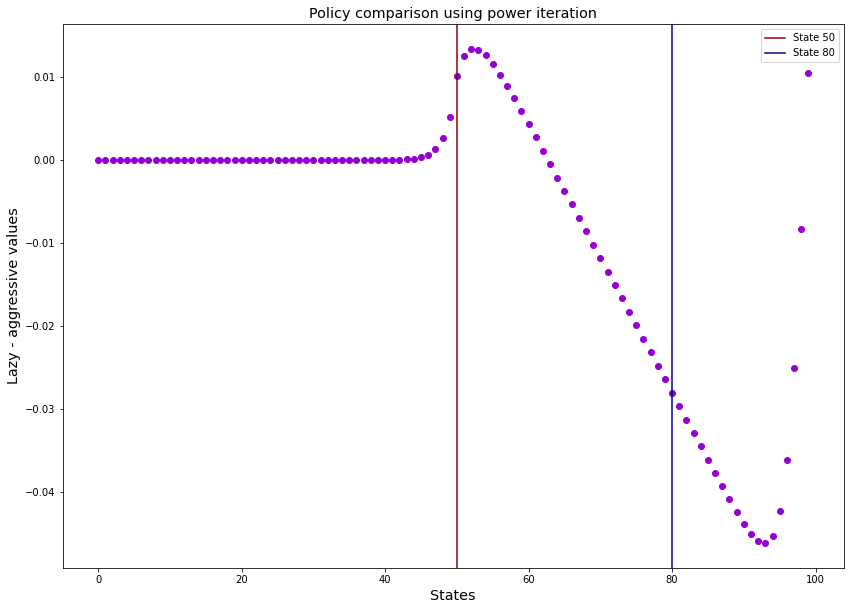

In [6]:
plt.figure(figsize=(14,10))
plt.scatter(range(N), y = lazy_values - agg_values, c='darkviolet')
plt.title('Policy comparison using power iteration',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Lazy - aggressive values',fontsize='x-large')
plt.axvline(x=50, c='darkred', label='State 50')
plt.axvline(x=80, c='darkblue', label='State 80')
plt.legend()
plt.show()

## Bellman equations

In order to solve the Bellman equations, we will need a transition matrix with all the corresponding probabilities of each state. Therefore, we define the function below that computes the corresponding matrix according to the given policy type.

In [7]:
def transition_matrix(N, pol_type, q_low, q_high, p): 
    """
    Defines the transition matrix with all the corresponding
    queue movement probabilities associated to each state,
    according to a policy type given as input.
    Three cases are identified, each one with specific expressions 
    for the probability of each queue movement:
    empty queue, full queue and all the values in between.
    We define p_dec, p_inc and 
    p_eq as the probabilities of the queue decreasing, increasing and staying equal,
    respectively, as the combined probabilities according to each case.
    
    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    
    """
    transition_mat = np.zeros((N,N))
    policy = policy_type(N, pol_type)
    for x in range(N):
        q = action(policy[x], q_low, q_high)
        if x != 0 and x != N-1: 
            p_dec = (1-p)*q
            p_inc = p*(1-q)
            p_eq = p*q+(1-p)*(1-q)
            transition_mat[x, x] = p_eq
            transition_mat[x,x+1] = p_inc
            transition_mat[x,x-1] = p_dec
        else:
            if x == 0:
                p_dec = 0.0
                p_inc = p*(1-q)
                p_eq = 1-p*(1-q)
                transition_mat[x,x] = p_eq
                transition_mat[x,x+1] = p_inc
            else:
                p_dec = (1-p)*q
                p_inc = 0
                p_eq = 1 - (1-p)*q
                transition_mat[x,x] = p_eq
                transition_mat[x,x-1] = p_dec
    return transition_mat

In [8]:
def bellman_solution(N,pol_type,q_low,q_high,p,gamma,optimal_policy=None):
    """
    Directly solves the Bellman equations. Calls the transition matrix
    and policy functions, computes the reward vector and returns the 
    corresponding value function.

    N: maximum state (N-1 if starting at 0)
    pol_type: policy type
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    gamma: discount factor
    optimal_policy: used for problem 2, when optimal policies are obtained
    """
    rewards = np.zeros(N)
    policy = optimal_policy if optimal_policy is not None else policy_type(N, pol_type)
    transition_mat = transition_matrix(N,pol_type,q_low,q_high,p)
    for x in range(N):
        rewards[x] = reward(policy[x],q_low,q_high,x,N)
    I = np.eye(N)
    values = np.linalg.inv(I-gamma*transition_mat).dot(rewards)
    return values

In [9]:
lazy_bellman = bellman_solution(N=N,pol_type='lazy', q_low=q_low, q_high=q_high, p=p, gamma=gamma)
agg_bellman = bellman_solution(N=N,pol_type='agg', q_low=q_low, q_high=q_high, p=p, gamma=gamma)

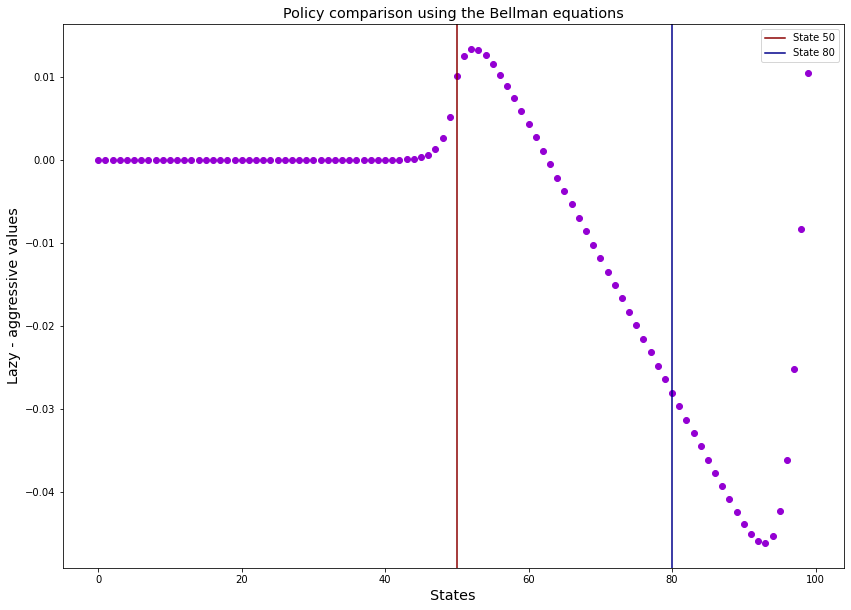

In [10]:
plt.figure(figsize=(14,10))
plt.scatter(range(100), y = lazy_bellman - agg_bellman, c='darkviolet')
plt.title('Policy comparison using the Bellman equations',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Lazy - aggressive values',fontsize='x-large')
plt.axvline(x=50, c='darkred', label='State 50')
plt.axvline(x=80, c='darkblue', label='State 80')
plt.legend()
plt.show()

## Discussion of both methods

As we can see and expect, both methods provide the same results. Moreover, it is also expected to obtain a null difference until we get close to the 50th state, where policy changes; from that point, we can see the fluctuations caused by the service rate change. Moreover, we can also see that the interval of states in which the difference is positive is a shorter interval than the one corresponding to negative differences. In other words, during the fluctuation zone, the aggressive policy has a higher value function than the lazy in more states, therefore being a better policy overall. Let us now discuss the two particular cases specified in the instructions.

To begin with, for the 50th state we can see that we have a positive value of the difference between the lazy and aggressive value functions, which means that the lazy policy works better than the aggressive in this state since it has a higher value function.

Then, in the 80th state, the difference value is negative, meaning that the lazy policy has a lower value function than the aggressive one. Therefore, oppositely to the previous case we just analyzed, here we have that the aggressive policy is better than the lazy one, since its value function is higher.

# Problem 2

Now, for this second problem, we will be obtaining the optimal policy using the two following methods: policy iteration and value iteration. For each one of them, we will be computing the value functions for different values for the maximum amount of iterations used. We finally store these results in DataFrame objects. Moreover, we also store the optimal policy obtained for each iteration and method. Finally, we will be comparing the obtained optimal policy with both lazy and aggressive policies from problem 1, by means of plotting the difference between the value functions associated to each policy. 

Below, we describe the two methods inside each function, plot all the requested results for each method and comment them.

## Policy iteration

In [11]:
def policy_iteration(N, initial_pol, update_pol, pol_type_low, pol_type_high, q_low, q_high, p, max_iter, gamma):
    """
    Iterates over all the states during a maximum number of iterations
    and computes two value functions at each state for the two possible actions. 
    Morever, three cases are identified, each one with specific expressions for 
    the probability of each queue movement:
    empty queue, full queue and all the values in between. At each state,
    if the value function corresponding to the initial action type is
    lower than the other (the one that will update the result), the optimal policy
    is updated accordingly. In other words, if initialized at 'low', if the value
    for 'high' is greater than the one for 'low', it is updated from 'low' to 'high',
    and viceversa if initialized oppositely.
    
    N: maximum state (N-1 if starting at 0)
    initial_pol: policy type to be initialized
    update_pol: action to be updated if it is the case
    pol_type_low: policy full of low actions
    pol_type_high: policy full of high actions
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    max_iter: maximum number of iterations
    gamma: discount factor
    
    """
    optimal_policy = list(policy_type(N,initial_pol))
    low_pol_matrix = transition_matrix(N,pol_type_low,q_low,q_high,p)
    high_pol_matrix = transition_matrix(N,pol_type_high,q_low,q_high,p) 
  
    for k in range(max_iter):
        policy_value = power_iteration(N,optimal_policy,max_iter,q_low,q_high,p,gamma)
        for x in range(N):
            if x==0:
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x+1]*policy_value[x+1] + low_pol_matrix[x,x]*policy_value[x])
                
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x+1]*policy_value[x+1] + high_pol_matrix[x,x]*policy_value[x])        

            elif (x>0) and (x < N - 1):
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x+1]*policy_value[x+1] + low_pol_matrix[x,x]*policy_value[x] + \
                 low_pol_matrix[x,x-1]*policy_value[x-1])
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x+1]*policy_value[x+1] + high_pol_matrix[x,x]*policy_value[x] + \
                 high_pol_matrix[x,x-1]*policy_value[x-1])
            else:
                value_a_low = reward(pol_type_low,q_low,q_high,x,N) + gamma*\
                (low_pol_matrix[x,x]*policy_value[x]+low_pol_matrix[x,x-1]*policy_value[x-1])
                value_a_high = reward(pol_type_high,q_low,q_high,x,N) + gamma*\
                (high_pol_matrix[x,x]*policy_value[x] + high_pol_matrix[x,x-1]*policy_value[x-1])

            if initial_pol == pol_type_low:
                if value_a_high > value_a_low:
                    optimal_policy[x] = update_pol
            else:
                if value_a_low > value_a_high:
                    optimal_policy[x] = update_pol                
  
    return optimal_policy

In [12]:
pol_it_results = []
pol_it_policies = []
for iter in [10,20,50,100]:
    optimal_policy = policy_iteration(N=N, initial_pol = 'low', update_pol = 'high', pol_type_low='low', \
                                      pol_type_high='high',q_low=q_low, q_high=q_high,p=p, \
                                      max_iter=iter, gamma=gamma)
    values = power_iteration(N=N,pol_type='None',max_iter=iter, q_low=q_low, q_high=q_high, p=p, \
                             gamma=gamma, optimal_policy=optimal_policy)
    pol_it_results.append(list(values))
    pol_it_policies.append(optimal_policy)

In [13]:
pd.set_option('display.max_columns', None)
pol_it_policies = pd.DataFrame(pol_it_policies)
print('Each row contains the policy corresponding to each maximum amount of iterations used: 10, 20, 50 and 100.')
pol_it_policies

Each row contains the policy corresponding to each maximum amount of iterations used: 10, 20, 50 and 100.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low
1,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low
2,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low
3,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low


In [14]:
pol_it_results = pd.DataFrame(pol_it_results).transpose()
pol_it_results.columns  = ['10_it','20_it','50_it','100_it']
pol_it_results['states'] = list(range(100))
pol_it_results

,10_it,20_it,50_it,100_it,states
0,-0.000856,-0.002088,-0.003136,-0.003186,0
1,-0.001877,-0.003453,-0.004583,-0.004632,1
2,-0.004098,-0.006370,-0.007732,-0.007783,2
3,-0.007677,-0.010994,-0.012722,-0.012778,3
4,-0.012693,-0.017404,-0.019627,-0.019691,4
...,...,...,...,...,...
95,-6.934554,-8.496521,-8.950295,-8.955701,95
96,-7.065936,-8.664513,-9.132893,-9.138537,96
97,-7.175296,-8.820914,-9.308260,-9.314202,97
98,-7.236253,-8.950067,-9.463157,-9.469480,98


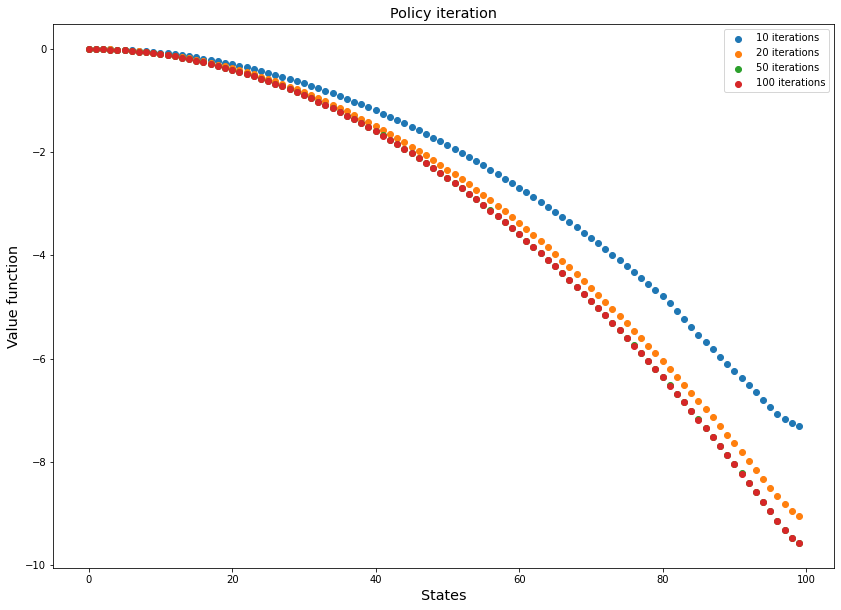

In [15]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'],pol_it_results['10_it'], label = '10 iterations')
plt.scatter(pol_it_results['states'],pol_it_results['20_it'], label = '20 iterations')
plt.scatter(pol_it_results['states'],pol_it_results['50_it'], label = '50 iterations')
plt.scatter(pol_it_results['states'],pol_it_results['100_it'], label = '100 iterations')
plt.title('Policy iteration', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend()
plt.show()

## Value iteration

In [16]:
def value_iteration(N,initial_pol,update_pol,pol_type_high,pol_type_low,q_low,q_high,p,max_iter,gamma):
    """
    Iterates over all the states during a maximum number of iterations
    and computes two value functions at each state for the two possible actions. 
    At each state, if the maximum value estimate is greater than the value function
    to be compared with, that value is updated with the corresponding estimate for that state.
    When all states have been looped over, the whole V value is updated with the vector
    that has been being updated during the states loop. Moreover, the optimal policy
    is being stored by updating the initial choosing as we did for policy iteration: 
    if initialized at 'low', if the value for 'high' is greater than the one for 'low', 
    it is updated from 'low' to 'high', and viceversa if initialized oppositely.
    
    N: maximum state (N-1 if starting at 0)
    initial_pol: policy type to be initialized
    update_pol: action to be updated if it is the case
    pol_type_low: policy full of low actions
    pol_type_high: policy full of high actions
    q_low: q value for low service rates
    q_high: q value for high service rates
    p: new requests arrival rate
    max_iter: maximum number of iterations
    gamma: discount factor
    
    """    
    V=np.zeros(N)
    low_pol_matrix = transition_matrix(N,pol_type_low,q_low,q_high,p)
    high_pol_matrix = transition_matrix(N,pol_type_high,q_low,q_high,p)
    optimal_policy = list(policy_type(N,initial_pol))
  
    for k in range(max_iter):

        Q_estimate_low = np.zeros(N)
        Q_estimate_high = np.zeros(N)
        V_next = -np.inf*np.ones(N)
        for x in range(N):

            Q_estimate_low[x] = reward(pol_type_low,q_low,q_high,x,N) + gamma*low_pol_matrix[x,:].dot(V)
            Q_estimate_high[x] = reward(pol_type_high,q_low,q_high,x,N) + gamma*high_pol_matrix[x,:].dot(V)
            
            if initial_pol == pol_type_low:
                if Q_estimate_low[x] < Q_estimate_high[x]:
                    optimal_policy[x] = update_pol
            else:
                if Q_estimate_low[x] > Q_estimate_high[x]:
                    optimal_policy[x] = update_pol                

            max_estimate = max(Q_estimate_low[x],Q_estimate_high[x])

            if max_estimate > V_next[x]:
                V_next[x] = max_estimate
        V = V_next
    return V, optimal_policy

In [17]:
val_it_results = []
val_it_policies = []
for iter in [10,20,50,100]:
    optimal_value, optimal_pol = value_iteration(N=N,initial_pol='low',update_pol='high',\
                                                 pol_type_high='high',pol_type_low='low',\
                                                 q_low=q_low,q_high=q_high,p=p,max_iter=iter,gamma=gamma)
    val_it_results.append(list(optimal_value))
    val_it_policies.append(optimal_pol)

In [18]:
val_it_policies = pd.DataFrame(val_it_policies)
print('Each row contains the policy corresponding to each maximum amount of iterations used: 10, 20, 50 and 100.')
val_it_policies

Each row contains the policy corresponding to each maximum amount of iterations used: 10, 20, 50 and 100.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
1,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low
2,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low
3,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low


In [19]:
val_it_results = pd.DataFrame(val_it_results).transpose()
val_it_results.columns  = ['10_it','20_it','50_it','100_it']
val_it_results['states'] = list(range(100))
val_it_results

,10_it,20_it,50_it,100_it,states
0,-0.000754,-0.001860,-0.003070,-0.003185,0
1,-0.001642,-0.003110,-0.004507,-0.004631,1
2,-0.003653,-0.005862,-0.007642,-0.007782,2
3,-0.006896,-0.010247,-0.012612,-0.012777,3
4,-0.011417,-0.016331,-0.019490,-0.019690,4
...,...,...,...,...,...
95,-5.874447,-7.903911,-8.913830,-8.955431,95
96,-5.997261,-8.066427,-9.095771,-9.138149,96
97,-6.117155,-8.222922,-9.270451,-9.313531,97
98,-6.225738,-8.360827,-9.424464,-9.468124,98


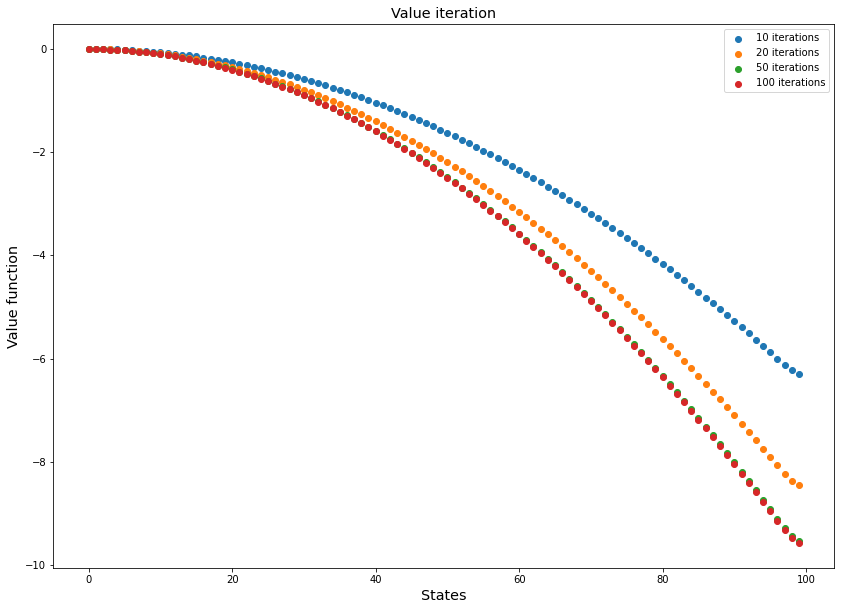

In [20]:
plt.figure(figsize=(14,10))
plt.scatter(val_it_results['states'],val_it_results['10_it'], label = '10 iterations')
plt.scatter(val_it_results['states'],val_it_results['20_it'], label = '20 iterations')
plt.scatter(val_it_results['states'],val_it_results['50_it'], label = '50 iterations')
plt.scatter(val_it_results['states'],val_it_results['100_it'], label = '100 iterations')
plt.title('Value iteration', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend()
plt.show()

## Discussion of both methods

### Convergence 

Firstly, comparing the 4 values of iterations used with each other, we can see that higher iteration values imply faster convergence, for both the policy iteration and the value iteration results. Moreover, we can also see no difference when using 50 or 100 iterations, implying that from a limit value, the behavior is almost equivalent at all states.

Now, in order to be able to compare methods and see which one converges faster to the optimal value function in terms of the number of iterations, we will plot each realization corresponding to each maximum amount of iterations used for both method. Below we display these results.

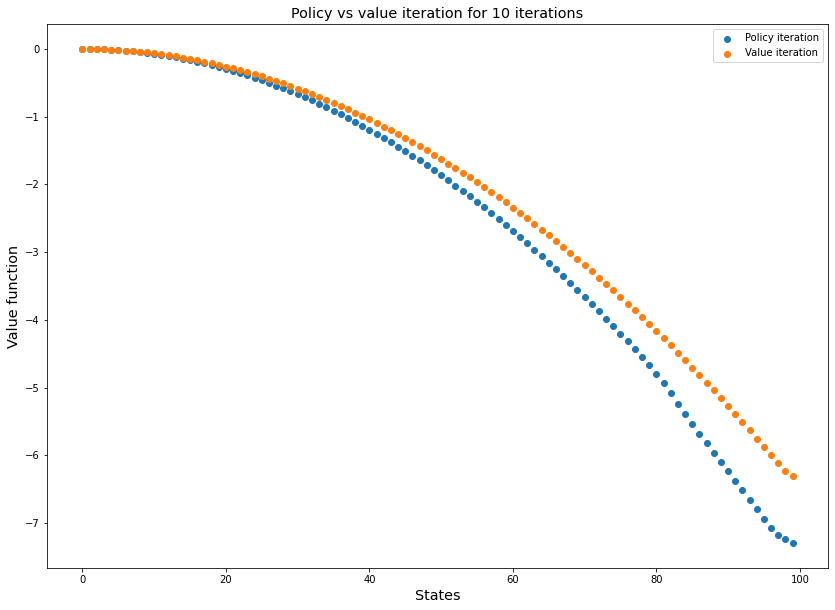

In [21]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'],pol_it_results['10_it'], label = 'Policy iteration')
plt.scatter(val_it_results['states'],val_it_results['10_it'], label = 'Value iteration')
plt.title('Policy vs value iteration for 10 iterations', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend()
plt.show()

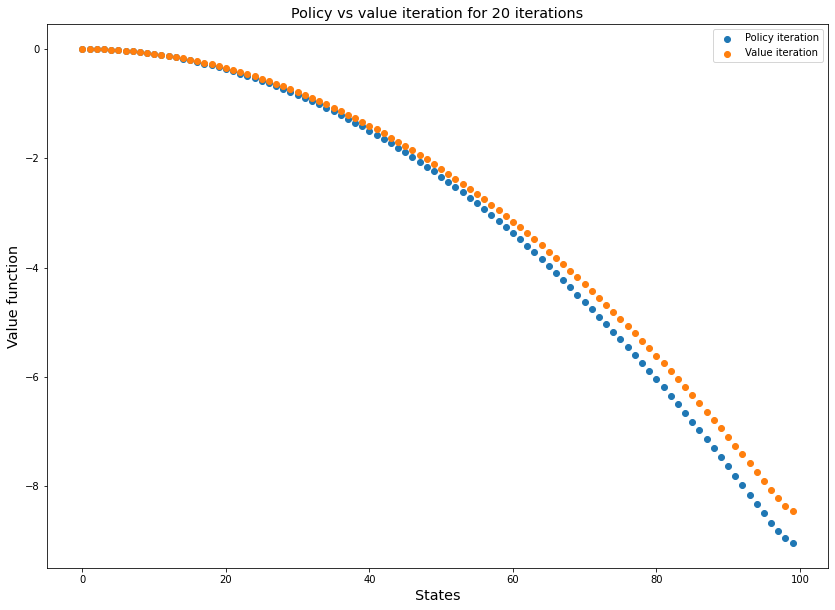

In [22]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'],pol_it_results['20_it'], label = 'Policy iteration')
plt.scatter(val_it_results['states'],val_it_results['20_it'], label = 'Value iteration')
plt.title('Policy vs value iteration for 20 iterations', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend()
plt.show()

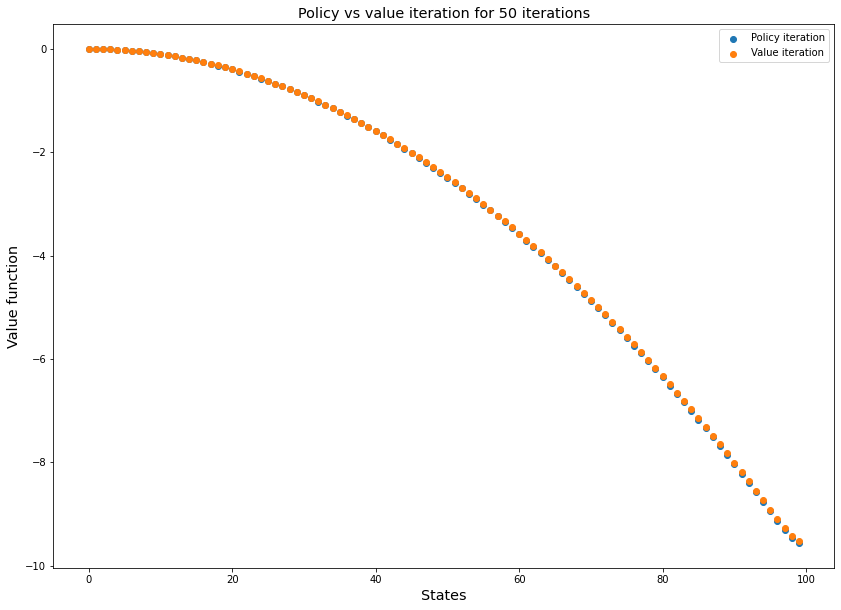

In [23]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'],pol_it_results['50_it'], label = 'Policy iteration')
plt.scatter(val_it_results['states'],val_it_results['50_it'], label = 'Value iteration')
plt.title('Policy vs value iteration for 50 iterations', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend()
plt.show()

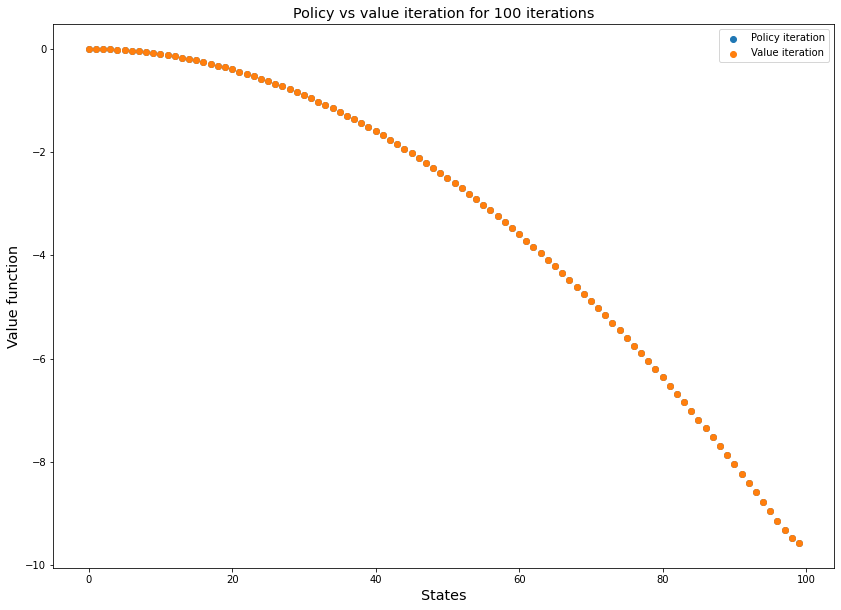

In [24]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'],pol_it_results['100_it'], label = 'Policy iteration')
plt.scatter(val_it_results['states'],val_it_results['100_it'], label = 'Value iteration')
plt.title('Policy vs value iteration for 100 iterations', fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Value function', fontsize='x-large')
plt.legend()
plt.show()

As we can see, policy iteration converges faster than value iteration when we use 10 and 20 as the maximum number of iterations. However, there is no difference between both methods using 50 or 100 iterations: both of them converge equivalently with a high amount of iterations, which is in concordance with what we already discussed before.

### Comparing runtimes between both methods

Below we have computed and displayed the runtimes of both methods for the 100 iterations case.

In [25]:
start = datetime.now()

optimal_policy = policy_iteration(N=N, initial_pol = 'high', update_pol = 'low', pol_type_low='low', \
                                      pol_type_high='high',q_low=q_low, q_high=q_high,p=p, \
                                      max_iter=max_iter, gamma=gamma)

end = datetime.now()
total_time_pol = (end-start).total_seconds()
print('The running time of the policy iteration method for 100 iterations and 100 states is ', \
      total_time_pol, 'seconds.')

The running time of the policy iteration method for 100 iterations and 100 states is  1.226713 seconds.


In [26]:
start = datetime.now()

optimal_value, optimal_pol = value_iteration(N=N,initial_pol='low',update_pol='high',\
                                                 pol_type_high='high',pol_type_low='low',\
                                                 q_low=q_low,q_high=q_high,p=p,max_iter=max_iter,gamma=gamma)

end = datetime.now()
total_time_val = (end-start).total_seconds()
print('The running time of the value iteration method for 100 iterations and 100 states is ', \
      total_time_val, 'seconds.')

The running time of the value iteration method for 100 iterations and 100 states is  0.020764 seconds.


As we can see, the policy iteration method is much slower than value iteration. For this small example, both methods are feasible in terms of computational efficience. However, this huge slowness of the policy iteration method can really be a disadvantage if dealing with a much higher state space. Since it takes a really short time to run for both methods using $N=100$, and a small change in these times can result in a heavily change on the ratio between running times (we know this after running these results several times), we will also show the results for $N=1000$, where the ratio stabilizes (it is always close to policy iteration being 45 times slower than value iteration).

In [27]:
start = datetime.now()

optimal_policy = policy_iteration(N=1000, initial_pol = 'high', update_pol = 'low', pol_type_low='low', \
                                      pol_type_high='high',q_low=q_low, q_high=q_high,p=p, \
                                      max_iter=max_iter, gamma=gamma)

end = datetime.now()
total_time_pol = (end-start).total_seconds()
print('The running time of the policy iteration method 100 iterations and 1000 states is ', \
      total_time_pol, 'seconds.')

The running time of the policy iteration method 100 iterations and 1000 states is  12.420335 seconds.


In [28]:
start = datetime.now()

optimal_value, optimal_pol = value_iteration(N=1000,initial_pol='low',update_pol='high',\
                                                 pol_type_high='high',pol_type_low='low',\
                                                 q_low=q_low,q_high=q_high,p=p,max_iter=max_iter,gamma=gamma)

end = datetime.now()
total_time_val = (end-start).total_seconds()
print('The running time of the value iteration method for 100 iterations and 1000 states is ', \
      total_time_val, 'seconds.')

The running time of the value iteration method for 100 iterations and 1000 states is  0.27467 seconds.


In [29]:
print('Policy iteration is ', total_time_pol/total_time_val, 'times slower than value iteration.')

Policy iteration is  45.219117486438265 times slower than value iteration.


### Optimal vs lazy and aggresive policies

To begin with, we show how the optimal policy is different from the two original ones, in terms of looking at the service rate it uses for each state, for the 100 maximum iterations case. Each row of the DataFrame below corresponds to a policy: optimal policy using policy iteration, optimal policy using value iteration, lazy policy and aggressive policy, respectively.

In [30]:
policy_comparison = pd.DataFrame([list(pol_it_policies.loc[3]), list(val_it_policies.loc[3]), \
                                  list(policy_type(N=N,pol_type='lazy')), list(policy_type(N=N,pol_type='agg'))])
policy_comparison

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low,low
1,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,low
2,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low
3,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high,high


As we can see, the optimal policies use a low service rate from the first state until the 62nd with policy iteration, or 63rd with value iteration. At that point, they change to using a high service rate, which lasts until the 97th (or 98th, with value iteration), where it changes back to a low service rate for the last state. First, note the existence of this small difference between optimal policies when using one method or the other: the value iteration lasts one more state in changing the service rate, which is a meaningless difference. Then, regarding the difference with the original policies, we can clearly see a difference with both of them, with the aggressive policy being closer to the optimal than the lazy one. 

Then, below we have displayed the graphical comparison with those original policies, by plotting the difference between both value functions for the case where the maximum number of iterations was 100, since it is the value we used in Problem 1.

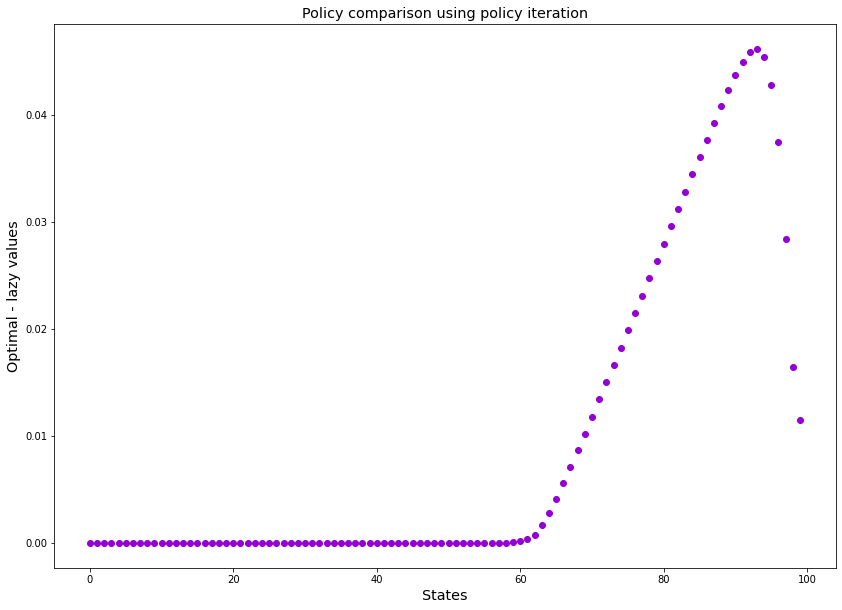

In [31]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'], y = pol_it_results['100_it'] - lazy_values, c='darkviolet')
plt.title('Policy comparison using policy iteration',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Optimal - lazy values',fontsize='x-large')
plt.show()

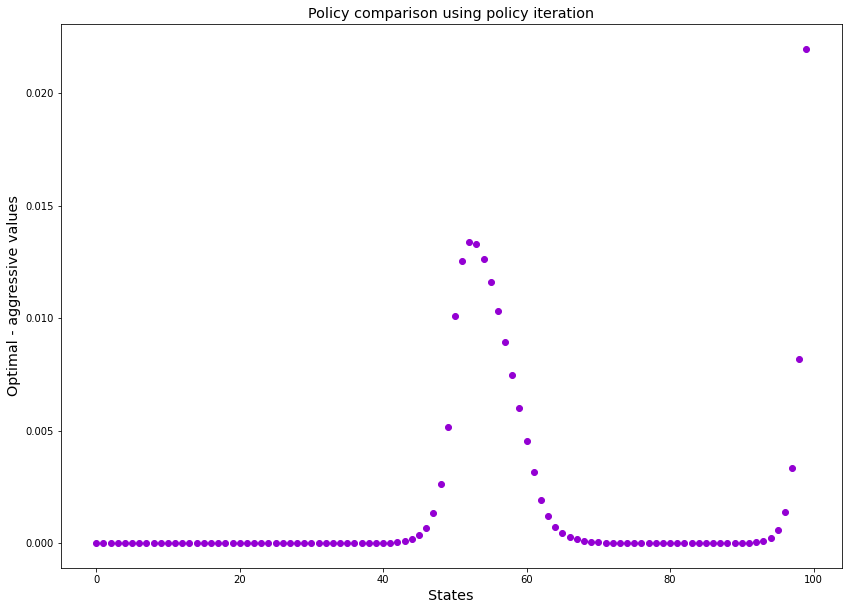

In [32]:
plt.figure(figsize=(14,10))
plt.scatter(pol_it_results['states'], y = pol_it_results['100_it'] - agg_values, c='darkviolet')
plt.title('Policy comparison using policy iteration',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Optimal - aggressive values',fontsize='x-large')
plt.show()

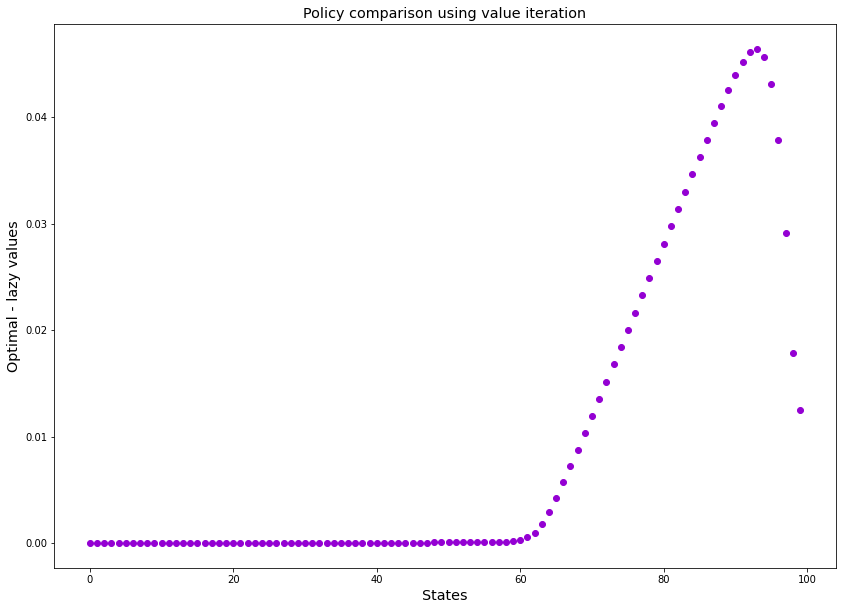

In [33]:
plt.figure(figsize=(14,10))
plt.scatter(val_it_results['states'], y = val_it_results['100_it'] - lazy_values, c='darkviolet')
plt.title('Policy comparison using value iteration',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Optimal - lazy values',fontsize='x-large')
plt.show()

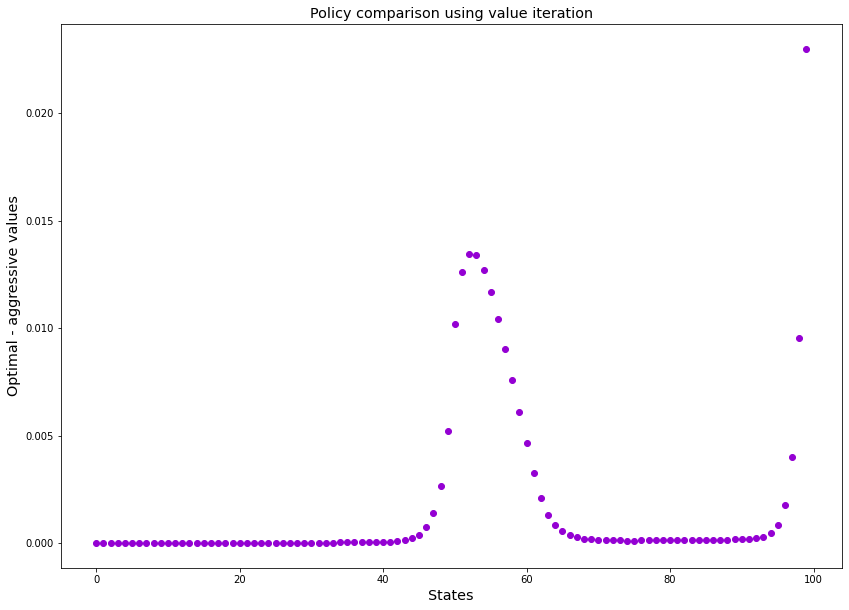

In [34]:
plt.figure(figsize=(14,10))
plt.scatter(val_it_results['states'], y = val_it_results['100_it'] - agg_values, c='darkviolet')
plt.title('Policy comparison using value iteration',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Optimal - aggressive values',fontsize='x-large')
plt.show()

To begin with, we must first point out that the results are equivalent using either policy or value iteration, which validates the performance of both methods. Then, let us comment both results.

The optimal policy outperforms the lazy policy from the 60th state until the last one: in that interval of states, we can observe a positive difference between the value functions, meaning that the optimal policy has a higher value function than the lazy one. However, we can also split this interval into two, according to the change of behavior it occurs around the 90th state: from the 60th to the 90th, we can see how the optimal policy keeps getting better than the lazy one at each state, while from 90th to the end, even though the optimal policy is still better than the lazy, the difference between them decreases.

Then, regarding the comparison with the aggressive policy, we can see different behaviors. Firstly, the optimal policy outperforms the aggressive around the $[40,60]$ state interval and also in the 5 last states, where the differences are positive. In this first mentioned interval, we can see how it keeps increasing in the first half of it, while it decreases in its second half until it again goes to 0, where there is no difference between policies. Then, it is also worth noting that, in the last state, the difference between policies gets to its highest, point in which the optimal policy has most outperformed the aggressive policy. 


Finally, comparing the two plots (difference with lazy and with aggressive), we can see how, for the lazy comparison, the difference in value functions gets to a value higher than 0.04. However, when comparing with the aggressive, the difference roughly surpases the value of 0.02 in its last state. Therefore, we can see a higher difference when comparing the optimal with the lazy, rather than when comparing it with the aggresive. This is in concordance with what we discussed before, where the aggressive policy was closer to the optimal by looking at the service rate it used for each state. In order to better see this, below we display this last result, where we have plot together both comparisons (the optimal minus both of them), in order to see how the optimal policy has outperformed more the lazy than the aggressive.

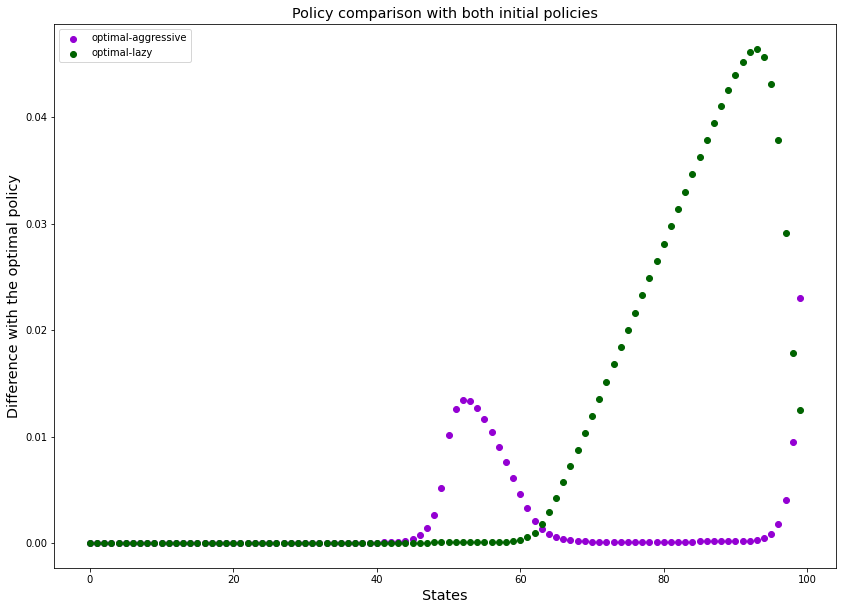

In [35]:
plt.figure(figsize=(14,10))
plt.scatter(val_it_results['states'], y = val_it_results['100_it'] - agg_values, c='darkviolet', \
            label='optimal-aggressive')
plt.scatter(val_it_results['states'], y = val_it_results['100_it'] - lazy_values, c='darkgreen', \
            label='optimal-lazy')
plt.title('Policy comparison with both initial policies',fontsize='x-large')
plt.xlabel('States', fontsize='x-large')
plt.ylabel('Difference with the optimal policy',fontsize='x-large')
plt.legend()
plt.show()